<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/hippocorpus_binaryclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
# import csv file as dataframe (from GitHub repo)
url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')
df_full = pd.read_csv(url, encoding='latin1') # for visualisation

# Clean data

In [3]:
# Are there missing values in the train set?
df.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge           23
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency            2756
importance            144
logTimeSinceEvent       0
mainEvent               0
memType                 0
mostSurprising          0
openness                0
recAgnPairId         4235
recImgPairId         1526
similarity           4098
similarityReason     4098
story                   0
stressful               0
summary                 0
timeSinceEvent          0
dtype: int64

In [4]:
# Okay, lots of missing values. Filling them with the mean value of the column
df["annotatorAge"] = df["annotatorAge"].fillna(df["annotatorAge"].mean())
df["frequency"] = df["frequency"].fillna(df["frequency"].mean())
df["importance"] = df["importance"].fillna(df["importance"].mean())
df["similarity"] = df["similarity"].fillna(df["similarity"].mean())

In [5]:
# Let's see if it worked
df.isnull().sum()

AssignmentId            0
WorkTimeInSeconds       0
WorkerId                0
annotatorAge            0
annotatorGender         0
annotatorRace           0
distracted              0
draining                0
frequency               0
importance              0
logTimeSinceEvent       0
mainEvent               0
memType                 0
mostSurprising          0
openness                0
recAgnPairId         4235
recImgPairId         1526
similarity              0
similarityReason     4098
story                   0
stressful               0
summary                 0
timeSinceEvent          0
dtype: int64

In [6]:
# sklearn does not like columns with categorical values
# make them binary dummy variables instead
df = pd.get_dummies(df, columns=["annotatorGender", "annotatorRace"])

In [7]:
# drop retold label
df = df[df.memType != 'retold']
df_full = df_full[df_full.memType != 'retold']

In [8]:
len(df['story'])

5535

In [9]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']


In [10]:
# drop categorical column
df = df.drop(columns='memType')

In [11]:
# AssignmentId, WorkerId, recAgnPairId and recImgPairId are practically unique for each individual and thus unusable for predictions
# mainEvent, mostSurprising, similarityReason, story and summary contain text and are unique to each individual
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
text_cols = ["mainEvent", "mostSurprising", "similarityReason", "story", "summary"]
df = df.drop(columns=uninformative_cols)
df = df.drop(columns=text_cols)

In [12]:
# age as binary measures
df['Old'] = np.where(df['annotatorAge']>=44, 1, 0)
df['Young'] = np.where(df['annotatorAge']>=25, 0, 1)
df['Middle1'] = np.where((df['annotatorAge']>=33) & (df['annotatorAge'] >=25), 1, 0)
df['Middle2'] = np.where((df['annotatorAge']>=44) & (df['annotatorAge'] >=33), 1, 0)

In [13]:
# drop gender and race columns
gender = ["annotatorGender_man", "annotatorGender_na", "annotatorGender_nonBinary", "annotatorGender_other", "annotatorGender_transman", "annotatorGender_transwoman", "annotatorGender_woman"]
df = df.drop(columns=gender)
race = ["annotatorRace_asian", "annotatorRace_black", "annotatorRace_hisp", "annotatorRace_indian", "annotatorRace_islander", "annotatorRace_middleEastern", "annotatorRace_na", "annotatorRace_native", "annotatorRace_other", "annotatorRace_white"]
df = df.drop(columns=race)

# Inspect data visually

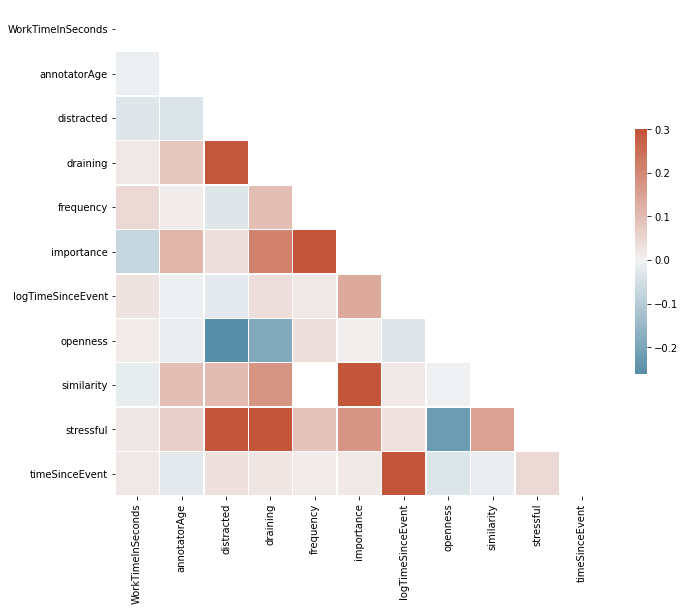

In [14]:
# Compute the correlation matrix
corr = df_full.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

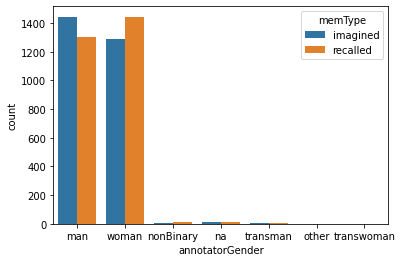

In [15]:
# histogram of gender and story type
sns.countplot(x="annotatorGender", hue="memType", data=df_full)

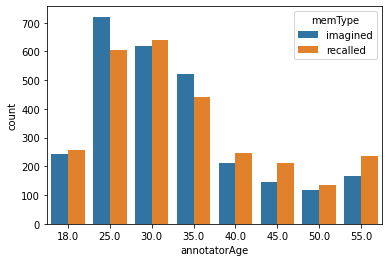

In [16]:
# histogram of age and story type
sns.countplot(x="annotatorAge", hue="memType", data=df_full)

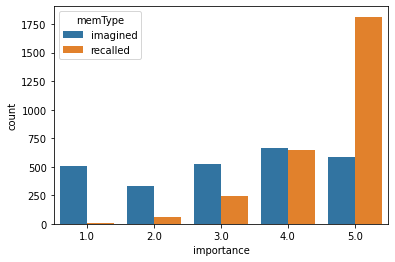

In [17]:
# histogram of importance and story type
sns.countplot(x="importance", hue="memType", data=df_full)

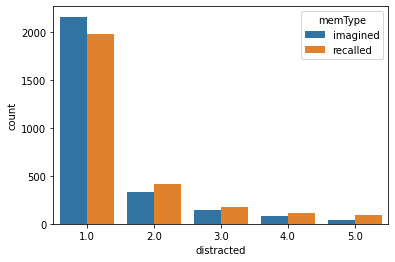

In [18]:
# histogram of distracted and story type
sns.countplot(x="distracted", hue="memType", data=df_full)

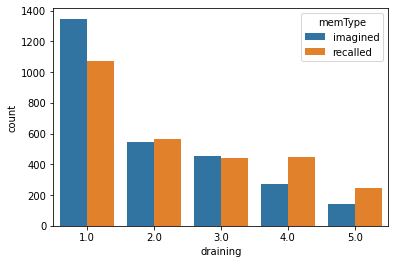

In [19]:
# histogram of draining and story type
sns.countplot(x="draining", hue="memType", data=df_full)

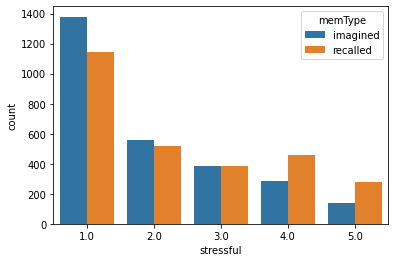

In [20]:
# histogram of stressful and story type
sns.countplot(x="stressful", hue="memType", data=df_full)

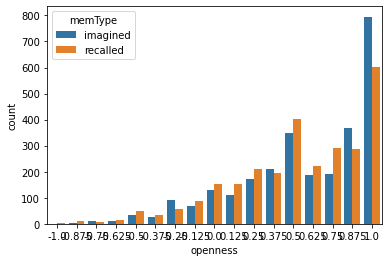

In [21]:
# histogram of openness and story type
sns.countplot(x="openness", hue="memType", data=df_full)

# Split into testing and training data

In [22]:
# split df into test and train
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [23]:
# Make subset of training data containing everything except the label
X = train.loc[:, train.columns != "label"]
# Make subset containing only the label
Y = train["label"]

# Test the model on the testing set
X_test = test.loc[:, train.columns != "label"]
Y_test = test["label"]

# Logistic Regression model

In [24]:
model = LogisticRegression()

# Fit model on training data
model.fit(X, Y)
# See how well the model does on the training data
yhat = model.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

# Test the model on the testing set
yhat_test = model.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.4993231046931408
Accuracy on test data: 0.49229374433363554


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[543,   0],
       [560,   0]])

In [27]:
print(classification_report(Y_test, yhat_test, digits=3))

              precision    recall  f1-score   support

           0      0.492     1.000     0.660       543
           1      0.000     0.000     0.000       560

    accuracy                          0.492      1103
   macro avg      0.246     0.500     0.330      1103
weighted avg      0.242     0.492     0.325      1103



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
matthews_corrcoef(Y_test, yhat_test)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

# Ridge classifier

In [28]:
model_rid = RidgeClassifier()

# Fit model on training data
model_rid.fit(X, Y)

# See how well the model does on the training data
yhat = model_rid.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

yhat_test = model_rid.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.8064079422382672
Accuracy on test data: 0.827742520398912


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.4053e-119): result may not be accurate.
  overwrite_a=True).T


array([[436, 107],
       [ 83, 477]])

In [29]:
# Cross-validation - 10fold
scores_rid = cross_val_score(model_rid, X, Y, cv=10)
scores_rid = pd.Series(scores_rid)
scores_rid.min(), scores_rid.mean(), scores_rid.max()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.38301e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.15964e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40346e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.54712e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40325e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: 

(0.7765237020316027, 0.803250259288634, 0.8239277652370203)

In [30]:
print(classification_report(Y_test, yhat_test, digits=3))

              precision    recall  f1-score   support

           0      0.840     0.803     0.821       543
           1      0.817     0.852     0.834       560

    accuracy                          0.828      1103
   macro avg      0.828     0.827     0.828      1103
weighted avg      0.828     0.828     0.828      1103



In [31]:
matthews_corrcoef(Y_test, yhat_test)

0.655794239057198

# SGD Classifier

In [34]:
model_sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

# Fit model on training data
model_sgd.fit(X, Y)

# See how well the model does on the training data
yhat = model_sgd.predict(X)

print(f"Accuracy on train data: {accuracy_score(Y, yhat)}")
confusion_matrix(Y, yhat)

yhat_test = model_sgd.predict(X_test)
print(f"Accuracy on test data: {accuracy_score(Y_test, yhat_test)}")
confusion_matrix(Y_test, yhat_test)

Accuracy on train data: 0.7903880866425993
Accuracy on test data: 0.8096101541251133


array([[442, 101],
       [109, 451]])

In [35]:
# Cross-validation - 10fold
scores_rid = cross_val_score(model_rid, X, Y, cv=10)
scores_rid = pd.Series(scores_rid)
scores_rid.min(), scores_rid.mean(), scores_rid.max()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.38301e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.15964e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40346e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.54712e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.40325e-119): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: 

(0.7765237020316027, 0.803250259288634, 0.8239277652370203)

In [36]:
print(classification_report(Y_test, yhat_test, digits=3))

              precision    recall  f1-score   support

           0      0.802     0.814     0.808       543
           1      0.817     0.805     0.811       560

    accuracy                          0.810      1103
   macro avg      0.810     0.810     0.810      1103
weighted avg      0.810     0.810     0.810      1103



In [37]:
matthews_corrcoef(Y_test, yhat_test)

0.6192801474422293